<a href="https://colab.research.google.com/github/Tech-Prep-Mentor/Food-Recommendation-Data/blob/main/food_category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploratory data analysis
**Dataset:** [Food Recommender](https://www.kaggle.com/code/aayushmishra1512/food-recommender/input?select=RAW_interactions.csv)

**Google Drive:** [Food_Recommender](https://drive.google.com/drive/folders/1HBhTdqGAqAmeFThYoBopaAe0SPu0HQb1?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.ensemble import IsolationForest
warnings.filterwarnings('ignore')

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Import recipes dataset
df = pd.read_csv('/content/drive/MyDrive/Group Project/RAW_recipes.csv')
df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


There are null values in the columns 'name' and 'description'

Some names and ingredients are repeated

In [ ]:
# prompt: print all tags in the first row

df.loc[0, 'tags'].split()


["['60-minutes-or-less',",
 "'time-to-make',",
 "'course',",
 "'main-ingredient',",
 "'cuisine',",
 "'preparation',",
 "'occasion',",
 "'north-american',",
 "'side-dishes',",
 "'vegetables',",
 "'mexican',",
 "'easy',",
 "'fall',",
 "'holiday-event',",
 "'vegetarian',",
 "'winter',",
 "'dietary',",
 "'christmas',",
 "'seasonal',",
 "'squash']"]

## Data cleaning

In [ ]:
# Replace NaN recipe name with Unamed
df['name'] = df['name'].fillna('Unnamed')

df.isna().sum()

name                 0
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

In [ ]:
df.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [ ]:
# Get nutrition information from table description
nutritions = ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']

# Split nutrition into different values columns
df[[nu for nu in nutritions]] = df.nutrition.str.split(",",expand=True)
df.drop(columns=['nutrition'], inplace=True)

# Since the nutrition column is a string, we need to remove the characters and convert it to float
for nu in nutritions:
    df[nu] = df[nu].str.extract('(\d+.\d+)', expand=False).astype(float) # Extract number value

In [ ]:
# Assuming you have a DataFrame called 'df' with the columns specified in numerical_columns
numerical_columns = ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']

# Create an IsolationForest object
isol = IsolationForest(contamination='auto')

# Fit the IsolationForest model to the numerical columns
isol.fit(df[numerical_columns])

# Predict the outliers
outliers = isol.predict(df[numerical_columns])

# Create a boolean mask to filter out outliers
mask = outliers != -1

df = df[mask]


In [ ]:
df = df[['name','ingredients','calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']]
df

,name,ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates
0,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ...",51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg...",173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato...",269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n...",368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar...",352.9,1.0,337.0,23.0,3.0,0.0,28.0
...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,"['celery', 'onion', 'green sweet pepper', 'gar...",415.2,26.0,34.0,26.0,44.0,21.0,15.0
231633,zydeco spice mix,"['paprika', 'salt', 'garlic powder', 'onion po...",14.8,0.0,2.0,58.0,1.0,0.0,1.0
231634,zydeco ya ya deviled eggs,"['hard-cooked eggs', 'mayonnaise', 'dijon must...",59.2,6.0,2.0,3.0,6.0,5.0,0.0
231635,cookies by design cookies on a stick,"['butter', 'eagle brand condensed milk', 'ligh...",188.0,11.0,57.0,11.0,7.0,21.0,9.0


In [ ]:
df.head(30)

,name,ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates
0,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ...",51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg...",173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato...",269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n...",368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar...",352.9,1.0,337.0,23.0,3.0,0.0,28.0
5,apple a day milk shake,"['milk', 'vanilla ice cream', 'frozen apple ju...",160.2,10.0,55.0,3.0,9.0,20.0,7.0
6,aww marinated olives,"['fennel seeds', 'green olives', 'ripe olives'...",380.7,53.0,7.0,24.0,6.0,24.0,6.0
10,berry good sandwich spread,"['whole berry cranberry sauce', 'sour cream', ...",79.2,3.0,58.0,0.0,0.0,6.0,5.0
11,better than sex strawberries,"['vanilla wafers', 'butter', 'powdered sugar',...",734.1,66.0,199.0,10.0,10.0,117.0,28.0
12,better then bush s baked beans,"['great northern bean', 'chicken bouillon cube...",462.4,28.0,214.0,69.0,14.0,29.0,23.0


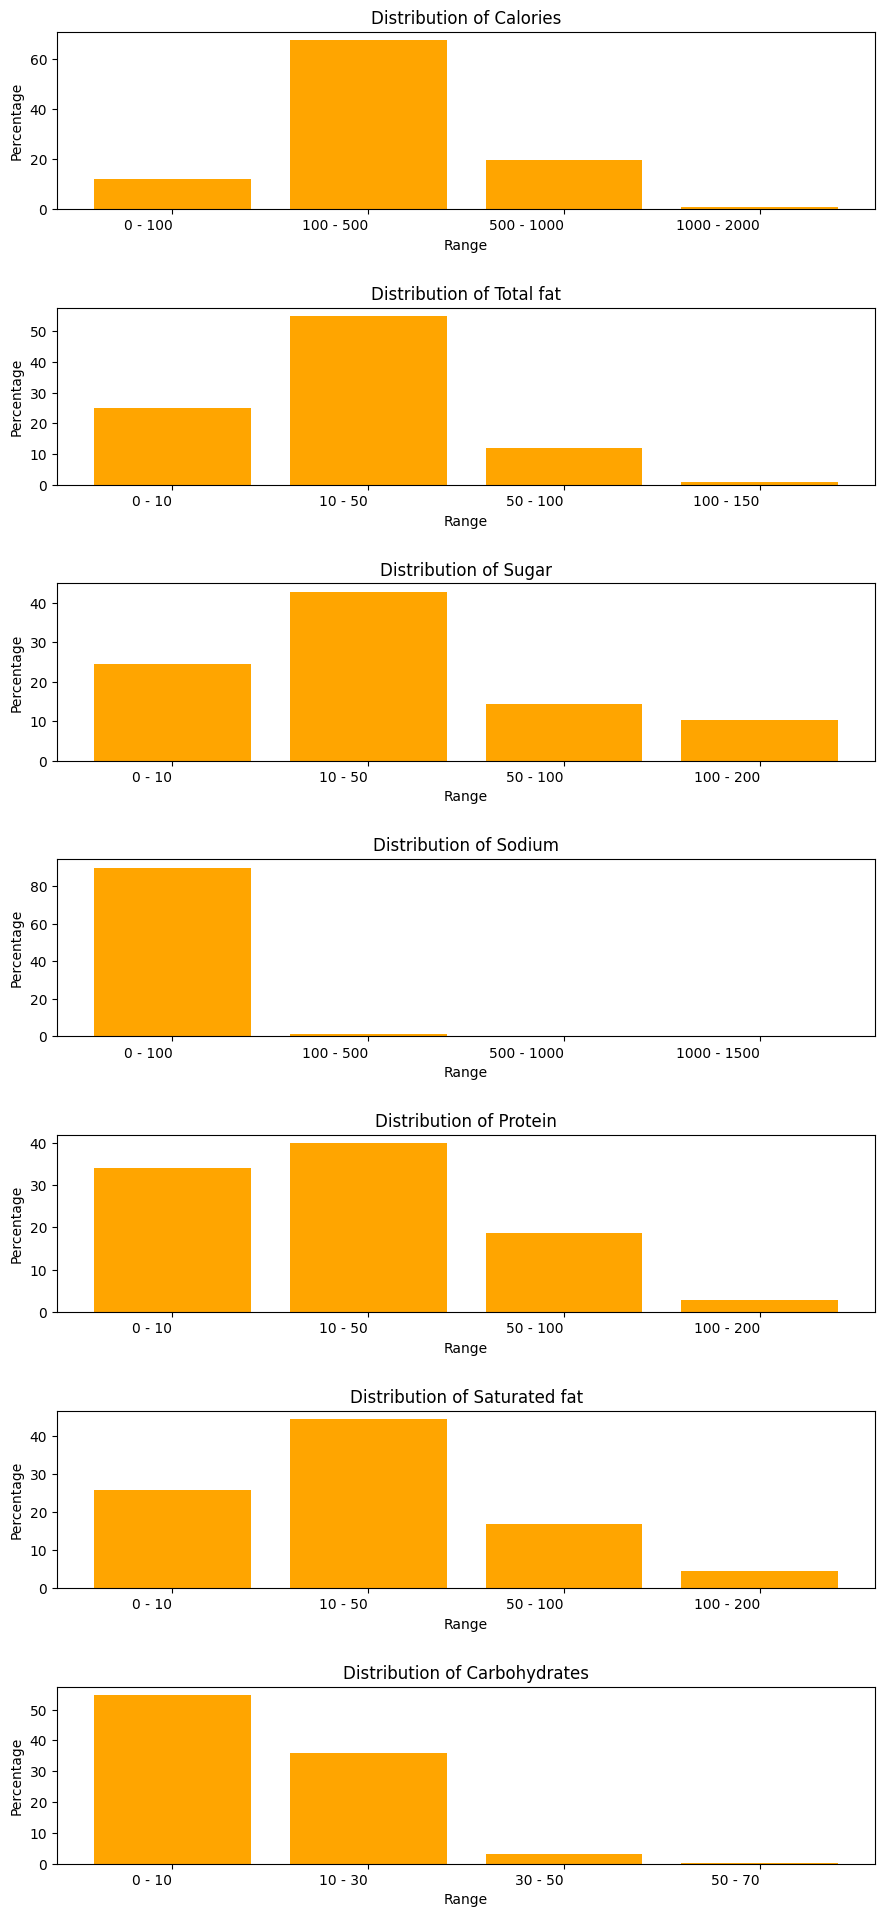

In [ ]:
import pandas as pd


# Function to calculate percentage distribution in specified ranges
def calculate_distribution(df, column, ranges):
    distribution = {}
    total_count = len(df)

    for i in range(len(ranges) - 1):
        lower_bound = ranges[i]
        upper_bound = ranges[i + 1]
        count = len(df[(df[column] > lower_bound) & (df[column] <= upper_bound)])
        percentage = (count / total_count) * 100
        distribution[f"{lower_bound} - {upper_bound}"] = percentage


    return distribution

# Define the ranges for each nutrient
nutrient_ranges = {
    'calories': [0, 100, 500, 1000, 2000],
    'total fat': [0, 10, 50, 100, 150],
    'sugar': [0, 10, 50, 100, 200],
    'sodium': [0, 100, 500, 1000, 1500],
    'protein': [0, 10, 50, 100, 200],
    'saturated fat': [0, 10, 50, 100, 200],
    'carbohydrates': [0, 10, 30, 50, 70]
}

# Calculate distribution for each nutrient and store for plotting
distributions = {}
for nutrient, ranges in nutrient_ranges.items():
    distributions[nutrient] = calculate_distribution(df, nutrient, ranges)

# Plot the distributions
fig, axes = plt.subplots(len(nutrient_ranges), 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

for i, (nutrient, distribution) in enumerate(distributions.items()):
    ax = axes[i]
    labels, values = zip(*distribution.items())
    ax.bar(labels, values, color='orange')
    ax.set_title(f"Distribution of {nutrient.capitalize()}")
    ax.set_xlabel("Range")
    ax.set_ylabel("Percentage")
    ax.set_xticklabels(labels, rotation=0, ha='right')

plt.show()


In [ ]:
# Print the min and max values for each nutrient
nutrients = ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
for nutrient in nutrients:
    min_value = df[nutrient].min()
    max_value = df[nutrient].max()

thresholds = {nutrient: df[nutrient].quantile(0.8) for nutrient in nutrients}

# Print the thresholds
for nutrient, threshold in thresholds.items():
    print(f"{nutrient.capitalize()}: 80th Percentile = {threshold}")

Calories: 80th Percentile = 504.6
Total fat: 80th Percentile = 41.0
Sugar: 80th Percentile = 73.0
Sodium: 80th Percentile = 34.0
Protein: 80th Percentile = 53.0
Saturated fat: 80th Percentile = 53.0
Carbohydrates: 80th Percentile = 16.0


In [ ]:
# List of nutrients to consider (excluding calories)
nutrients = ['total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']

# Thresholds for dominance
thresholds = {
    'sugar': 72,
    'total fat': 41,
    'protein': 53,
    'sodium': 34,
    'saturated fat': 53,
    'carbohydrates': 16
}
def find_dominant_nutrients(row):
  dominant_nutrients = []
  for nutrient in nutrients:
    if nutrient in thresholds and row[nutrient] > thresholds[nutrient]:
        dominant_nutrients.append(nutrient)

  # If no nutrient exceeds the threshold, use the highest value logic
  if not dominant_nutrients:
    values = {nutrient: row[nutrient] for nutrient in nutrients}
    max_value = max(values.values())
    dominant_nutrients = [nutrient for nutrient, value in values.items() if value == max_value]

  return ', '.join(dominant_nutrients)

# Apply the function to each row
df['dominant_nutrients'] = df.apply(find_dominant_nutrients, axis=1)

df.head(10)


,name,ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates,dominant_nutrients
0,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ...",51.5,0.0,13.0,0.0,2.0,0.0,4.0,sugar
1,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg...",173.4,18.0,0.0,17.0,22.0,35.0,1.0,saturated fat
2,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato...",269.8,22.0,32.0,48.0,39.0,27.0,5.0,sodium
3,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n...",368.1,17.0,10.0,2.0,14.0,8.0,20.0,carbohydrates
4,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar...",352.9,1.0,337.0,23.0,3.0,0.0,28.0,"sugar, carbohydrates"
5,apple a day milk shake,"['milk', 'vanilla ice cream', 'frozen apple ju...",160.2,10.0,55.0,3.0,9.0,20.0,7.0,sugar
6,aww marinated olives,"['fennel seeds', 'green olives', 'ripe olives'...",380.7,53.0,7.0,24.0,6.0,24.0,6.0,total fat
10,berry good sandwich spread,"['whole berry cranberry sauce', 'sour cream', ...",79.2,3.0,58.0,0.0,0.0,6.0,5.0,sugar
11,better than sex strawberries,"['vanilla wafers', 'butter', 'powdered sugar',...",734.1,66.0,199.0,10.0,10.0,117.0,28.0,"total fat, sugar, saturated fat, carbohydrates"
12,better then bush s baked beans,"['great northern bean', 'chicken bouillon cube...",462.4,28.0,214.0,69.0,14.0,29.0,23.0,"sugar, sodium, carbohydrates"


In [ ]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

nutrient_sources = {
    'total fat': [
        'butter', 'cheese', 'nuts', 'oils', 'meats', 'avocado', 'chocolate', 'cream',
        'bacon', 'sausage', 'whole milk', 'peanut butter', 'almonds', 'walnuts', 'cashews', 'ground beef',
        'olive oil', 'canola oil', 'sesame oil', 'avocado oil', 'pecans', 'macadamia', 'pistachios', 'herring', 'mackerel',
        'ghee', 'sour cream', 'heavy cream'
    ],
    'sugar': [
        'sugar', 'honey', 'fruits', 'sweetened beverages', 'candies', 'desserts', 'syrups',
        'cakes', 'cookies', 'ice cream', 'jams', 'jellies', 'molasses', 'agave nectar', 'maple syrup',
        'brown sugar', 'confectioner sugar', 'bananas', 'apples', 'grapes', 'flavored yogurt', 'condensed milk'
    ],
    'sodium': [
        'salt', 'processed foods', 'canned foods', 'pickles', 'soy sauce', 'bacon', 'ham',
        'chips', 'pretzels', 'instant noodles', 'canned soups', 'frozen meals', 'deli meats', 'pizza',
        'garlic salt', 'celery salt', 'seasoning blends', 'feta cheese', 'blue cheese', 'salted nuts', 'popcorn'
    ],
    'protein': [
        'pork', 'chicken', 'turkey', 'beef', 'fish', 'shrimp', 'tofu', 'beans', 'lentils', 'soya',
        'eggs', 'nuts', 'seeds', 'quinoa', 'yogurt', 'milk', 'cheese', 'peas', 'edamame', 'tempeh', 'salmon', 'chickpeas', 'tuna',
        'venison', 'duck', 'spirulina', 'pumpkin seeds', 'cottage cheese', 'whey protein'
    ],
    'saturated fat': [
        'butter', 'cheese', 'red meat', 'coconut oil', 'palm oil', 'cream', 'bacon',
        'sausage', 'lard', 'pastries', 'cakes', 'ice cream', 'whole milk', 'chocolate', 'shortening',
        'mascarpone', 'ricotta', 'fatty cuts of lamb', 'pork belly', 'salami', 'pepperoni'
    ],
    'carbohydrates': [
        'bread', 'pasta', 'rice', 'potatoes', 'fruits', 'sugar', 'cereals', 'oats',
        'quinoa', 'barley', 'corn', 'peas', 'beans', 'lentils', 'crackers', 'starchy vegetables',
        'bulgur', 'couscous', 'spelt', 'yams', 'sweet potatoes', 'black beans', 'garbanzo beans'
    ]
}


def preprocess_ingredients(ingredients):
    # Tokenize and lowercase, but don't lemmatize
    tokens = word_tokenize(ingredients)
    tokens = [token.lower() for token in tokens if token not in string.punctuation]
    return tokens



In [ ]:
# Preprocess nutrient_sources
preprocessed_sources = {}
for nutrient, sources in nutrient_sources.items():
    preprocessed_sources[nutrient] = [
        set(preprocess_ingredients(source))
        for source in sources
    ]

def list_contributing_sources(row):
    dominant_nutrients = row['dominant_nutrients']
    ingredients = row['ingredients']

    # Early return if no dominant nutrients
    if not dominant_nutrients:
        return ""

    nutrients = set(dominant_nutrients.split(', '))
    ingredient_list = set(preprocess_ingredients(ingredients))

    matching_sources = set()
    for nutrient in nutrients:
        for source, source_words in zip(nutrient_sources[nutrient], preprocessed_sources[nutrient]):
            if source_words & ingredient_list:  # Set intersection
                matching_sources.add(source)

    return ', '.join(matching_sources) if matching_sources else ""

# Apply the function to each row
df['contributing_sources'] = df.apply(list_contributing_sources, axis=1)

In [ ]:
df

,name,ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates,dominant_nutrients,contributing_sources
0,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ...",51.5,0.0,13.0,0.0,2.0,0.0,4.0,sugar,
1,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg...",173.4,18.0,0.0,17.0,22.0,35.0,1.0,saturated fat,
2,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato...",269.8,22.0,32.0,48.0,39.0,27.0,5.0,sodium,"blue cheese, feta cheese"
3,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n...",368.1,17.0,10.0,2.0,14.0,8.0,20.0,carbohydrates,"potatoes, sweet potatoes"
4,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar...",352.9,1.0,337.0,23.0,3.0,0.0,28.0,"sugar, carbohydrates",
...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,"['celery', 'onion', 'green sweet pepper', 'gar...",415.2,26.0,34.0,26.0,44.0,21.0,15.0,protein,"peas, chicken"
231633,zydeco spice mix,"['paprika', 'salt', 'garlic powder', 'onion po...",14.8,0.0,2.0,58.0,1.0,0.0,1.0,sodium,
231634,zydeco ya ya deviled eggs,"['hard-cooked eggs', 'mayonnaise', 'dijon must...",59.2,6.0,2.0,3.0,6.0,5.0,0.0,"total fat, protein",eggs
231635,cookies by design cookies on a stick,"['butter', 'eagle brand condensed milk', 'ligh...",188.0,11.0,57.0,11.0,7.0,21.0,9.0,sugar,"confectioner sugar, ice cream, brown sugar, co..."


In [ ]:
# prompt: i want to list all ingredients in some rows, list all not justy a few

# Select the desired rows
df_subset = df.iloc[0:5]

# Extract and print the ingredients for each row
for index, row in df_subset.iterrows():
    ingredients = row['ingredients']
    print(f"Ingredients for row {index + 1}: {ingredients}")


Ingredients for row 1: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Ingredients for row 2: ['prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese']
Ingredients for row 3: ['ground beef', 'yellow onions', 'diced tomatoes', 'tomato paste', 'tomato soup', 'rotel tomatoes', 'kidney beans', 'water', 'chili powder', 'ground cumin', 'salt', 'lettuce', 'cheddar cheese']
Ingredients for row 4: ['spreadable cheese with garlic and herbs', 'new potatoes', 'shallots', 'parsley', 'tarragon', 'olive oil', 'red wine vinegar', 'salt', 'pepper', 'red bell pepper', 'yellow bell pepper']
Ingredients for row 5: ['tomato juice', 'apple cider vinegar', 'sugar', 'salt', 'pepper', 'clove oil', 'cinnamon oil', 'dry mustard']


In [ ]:
from wordcloud import WordCloud
# Filter to include only rows where dominant_nutrients contains a single nutrient
main_nutrients = ['total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
df_main_nutrients = df_missing_sources[df_missing_sources['dominant_nutrients'].isin(main_nutrients)]

# Group by dominant_nutrients
grouped = df_main_nutrients.groupby('dominant_nutrients')

# Create a word cloud for each group
for nutrient, group in grouped:
    ingredients = ' '.join(group['ingredients'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ingredients)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {nutrient.capitalize()}')
    plt.show()

NameError: name 'df_missing_sources' is not defined

In [ ]:
import pandas as pd
import re

# Assuming your DataFrame is named 'df'
# df = pd.read_csv('your_dataset.csv')

# Define category mappings
categories = {
    "Sweets & Snacks": [
        "Candy", "Gummies", "Hard Candy", "Chocolate Bars", "Mints",
        "Ice Cream & Frozen Yogurt", "Sorbet", "Gelato",
        "Chips, Pretzels & Snacks", "Potato Chips", "Tortilla Chips", "Popcorn", "Pretzels",
        "Cookies & Biscuits", "Chocolate Chip Cookies", "Shortbread", "Oatmeal Cookies",
        "Snack, Energy & Granola Bars", "Granola Bars", "Protein Bars",
        "Cakes, Cupcakes, Snack Cakes", "Cupcakes", "Cheesecakes", "Sponge Cakes"
    ],
    "Mixed Dishes": [
        "Frozen Dinners & Entrees", "TV Dinners", "Frozen Pasta Dishes",
        "Frozen Pizzas", "Thin Crust Pizza", "Deep Dish Pizza",
        "Prepared Pasta & Pizza Sauces",
        "Dips & Salsas", "Guacamole", "Hummus",
        "Salad Dressing & Mayonnaise", "Ranch Dressing", "Caesar Dressing",
        "Vegetable & Cooking Oils", "Olive Oil", "Canola Oil"
    ],
    "Grains": [
        "Cereal", "Corn Flakes", "Oatmeal",
        "Bread & Buns", "Whole Wheat Bread", "Baguettes",
        "Pasta, Shape & Type", "Spaghetti", "Macaroni",
        "Rice", "Brown Rice", "White Rice",
        "Quinoa & Ancient Grains", "Quinoa", "Farro"
    ],
    "Meats & Protein": [
        "Poultry", "Chicken", "Turkey",
        "Beef", "Steak", "Ground Beef",
        "Pork", "Pork Chops", "Bacon",
        "Seafood", [
            "Shrimp", "Salmon", "Tuna", "Crab", "Lobster",
            "Clams", "Scallops", "Mussels", "Oysters"
        ],
        "Nuts & Seeds", "Almonds", "Walnuts",
        "Beans & Peas", "Black Beans", "Lentils"
    ],
    "Beverages": [
        "Soda", "Cola", "Diet Soda",
        "Tea", "Green Tea", "Black Tea",
        "Coffee", "Espresso", "Latte",
        "Alcoholic Beverages", "Beer", "Wine",
        "Smoothies & Protein Shakes", "Fruit Smoothies", "shakes",
        "juice"
    ],
    "Fruits": [
        "Apples", "Bananas", "Grapes",
        "Berries", ["Strawberries", "Blueberries", "Raspberries"],
        "Citrus Fruits", ["Oranges", "Lemons", "Limes"],
        "Tropical Fruits", ["Mangoes", "Pineapples", "Papayas"],
        "Stone Fruits", ["Peaches", "Plums", "Cherries"],
        "Melons", ["Watermelon", "Cantaloupe", "Honeydew"],
        "Dried Fruits", ["Dates", "Raisins", "Dried Apricots"]
    ],
    "Vegetables": [
        "Leafy Greens", ["Spinach", "Kale", "Lettuce"],
        "Root Vegetables", ["Carrots", "Beets", "Turnips"],
        "Alliums", ["Onions", "Garlic", "Shallots"],
        "Brassicas", ["Broccoli", "Cauliflower", "Cabbage"],
        "Nightshades", ["Tomatoes", "Peppers", "Eggplants"],
        "Legumes", ["Peas", "Green Beans"],
        "Fresh Herbs", ["Basil", "Parsley", "Cilantro"],
        "Pickled & Fermented Vegetables", ["Pickles", "Sauerkraut", "Kimchi"]
    ],

        "Fats and Oils": [
        "Butter", "Salted Butter", "Unsalted Butter",
        "Margarine", "Regular Margarine", "Low-Fat Margarine",
        "Oils", "Vegetable Oil", "Canola Oil", "Sunflower Oil",
        "Animal Fats", "Lard", "Tallow", "Duck Fat",
        "Nut & Seed Oils", "Almond Oil", "Flaxseed Oil", "Peanut Oil",
        "Coconut Oil", "Virgin Coconut Oil", "Refined Coconut Oil",
        "Olive Oil", "Extra Virgin Olive Oil", "Light Olive Oil",
        "Specialty Oils", "Avocado Oil", "Grapeseed Oil", "Sesame Oil"
    ],
    "Condiments and Sauces": [
        "Ketchup", "Organic Ketchup", "Spicy Ketchup",
        "Mustard", "Yellow Mustard", "Dijon Mustard", "Whole Grain Mustard",
        "BBQ & Cheese Sauce", "Classic BBQ Sauce", "Hot BBQ Sauce", "Cheese Sauce",
        "Oriental, Mexican & Ethnic Sauces", "Soy Sauce", "Taco Sauce", "Curry Paste",
        "Pickles, Olives, Peppers & Relishes", "Dill Pickles", "Green Olives", "Red Pepper Relish",
        "Seasoning Mixes, Salts, Marinades & Tenderizers", "Steak Seasoning", "Sea Salt", "Meat Tenderizer",
        "Vinegar", "Balsamic Vinegar", "White Vinegar",
        "Soy Sauce & Sauce", "Light Soy Sauce", "Dark Soy Sauce",
        "Hot Sauces & Chili Oil", "Tabasco Sauce", "Sriracha", "Chili Oil",
        "Mayonnaise & Aioli", "Traditional Mayonnaise", "Garlic Aioli",
        "Pesto & Herb Sauces", "Basil Pesto", "Cilantro Lime Sauce"
    ],
    "Baking & Sweeteners": [
        "Baking Ingredients", "Baking Soda", "Baking Powder", "Yeast",
        "Natural Sweeteners", "Honey", "Agave Syrup", "Maple Syrup",
        "Refined Sugars", "Granulated Sugar", "Powdered Sugar", "Brown Sugar",
        "Artificial Sweeteners", "Aspartame", "Sucralose", "Stevia",
        "Flour & Meal", "All-Purpose Flour", "Whole Wheat Flour", "Almond Flour",
        "Baking Mixes", "Pancake Mix", "Brownie Mix", "Cake Mix",
        "Chocolate & Cocoa", "Dark Chocolate", "Milk Chocolate", "Cocoa Powder",
        "Dried Fruits & Nuts for Baking", "Raisins", "Walnuts", "Dried Cranberries"
    ],
    "Spices & Seasonings": [
        "Dried Herbs", "Thyme", "Rosemary", "Oregano",
        "Spices", "Cumin", "Turmeric", "Cinnamon",
        "Salt & Pepper", "Table Salt", "Black Pepper", "Himalayan Pink Salt",
        "Spice Blends", "Curry Powder", "Italian Seasoning", "Taco Seasoning",
        "Bouillon & Stock Cubes", "Chicken Bouillon", "Beef Bouillon", "Vegetable Bouillon",
        "Chili Powder & Paprika", "Chili Powder", "Smoked Paprika", "Sweet Paprika",
        "Cinnamon & Sweet Spices", "Ground Cinnamon", "Nutmeg", "Allspice",
        "Savory Spices", "Garlic Powder", "Onion Powder", "Mustard Seeds"
    ],
    "Salads & Produce": [
        "Pre-Made Salads", "Caesar Salad", "Greek Salad", "Cobb Salad",
        "Salad Greens", "Arugula", "Spinach", "Kale",
        "Salad Toppings", "Croutons", "Sunflower Seeds", "Dried Cranberries",
        "Grain & Pasta Salads", "Quinoa Salad", "Macaroni Salad", "Tabbouleh",
        "Fresh Produce", "Apples", "Tomatoes", "Carrots",
        "Pre-Cut Fruits & Vegetables", "Mixed Fruit Packs", "Veggie Sticks", "Salad Mix",
        "Sprouts & Microgreens", "Alfalfa Sprouts", "Broccoli Sprouts", "Microgreen Mix"
    ],
    "International Foods": [
        "Asian Foods", "Sushi Kits", "Ramen Noodles", "Stir Fry Sauces",
        "Mexican Foods", "Tortillas", "Salsa", "Refried Beans",
        "Indian Foods", "Curry Sauces", "Chutneys", "Basmati Rice",
        "Middle Eastern Foods", "Hummus", "Falafel", "Pita Bread",
        "European Specialties", "French Cheeses", "Italian Pasta", "German Sausages",
        "Latin American Foods", "Empanada Dough", "Aji Amarillo Paste", "Dulce de Leche",
        "African Foods", "Berbere Spice", "Fufu Flour", "Harissa Paste"
    ],

    "Baby Foods": [
        "Baby Foods", "Pureed Fruit", "Pureed Vegetables", "Meat Purees",
        "Baby Formula", "Milk-Based Formula", "Soy-Based Formula", "Hypoallergenic Formula",
        "Baby Snacks", "Teething Biscuits", "Puffs", "Baby Cereal"
    ],
    "Other": [
        "Other", "Miscellaneous Items", "Seasonal & Holiday Foods", "Christmas Cookies",
        "Gourmet & Artisanal Products", "Artisanal Cheeses", "Gourmet Chocolates", "Specialty Oils",
        "Ready-to-Drink Beverages", "Bottled Smoothies", "Iced Teas", "Cold Brew Coffee",
        "Meal Kits & Subscription Boxes", "Meal Delivery Kits", "Snack Boxes", "Gourmet Meal Kits"
    ]
}
    # Co          ntinue with other main categories...


In [ ]:
from collections import defaultdict
# Function to preprocess the name
def preprocess_name(name):
    # Handle both individual strings and lists of strings
    if isinstance(name, list):
        return [preprocess_name(part) for part in name]  # Recursively preprocess each part
    name = name.lower()
    name = re.sub(r'[^\w\s]', '', name)  # Remove punctuation
    return name.split()

# Function to handle both flat and nested category lists
def add_keywords_to_category(keywords, category_name, keyword_to_category):
    # Ensure category_name is in lowercase to maintain consistency
    category_name = category_name.lower()
    if isinstance(keywords, list):
        for keyword in keywords:
            if isinstance(keyword, list):
                # Recursively process sublists
                add_keywords_to_category(keyword, category_name, keyword_to_category)
            else:
                # Process individual keywords and map them to the category
                for part in preprocess_name(keyword):
                    keyword_to_category[part].append(category_name)
    else:
        # Process a single keyword string
        for part in preprocess_name(keywords):
            keyword_to_category[part].append(category_name)

# Create a keyword-to-category mapping
keyword_to_category = defaultdict(list)

# Populate the mapping
for category, items in categories.items():
    if isinstance(items, dict):  # If the items is a dictionary, it has subcategories
        for subcategory, keywords in items.items():
            add_keywords_to_category(keywords, subcategory, keyword_to_category)
    else:
        add_keywords_to_category(items, category, keyword_to_category)

# Function to find the category of a recipe name
def find_category(recipe_name):
    words = preprocess_name(recipe_name)
    for word in words:
        if word in keyword_to_category:
            return keyword_to_category[word][0]  # Return the first matching category
    return ""

# Apply the functions to each recipe name

df['Category'] = df['name'].apply(find_category)

# Display the first few rows to check the results
print(df.head(10))

In [ ]:
# prompt: view rows that miss both category and contributing source and wordcloud ingredients, "" not isnull

import matplotlib.pyplot as plt
df_missing_both = df[(df['Category'] == "") & (df['contributing_sources'] == "")]

# Filter to include only rows where dominant_nutrients contains a single nutrient
main_nutrients = ['total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
df_missing_sources = df_missing_both[df_missing_both['dominant_nutrients'].isin(main_nutrients)]

# Group by dominant_nutrients
grouped = df_missing_sources.groupby('dominant_nutrients')

# Create a word cloud for each group
for nutrient, group in grouped:
    ingredients = ' '.join(group['ingredients'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ingredients)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {nutrient.capitalize()}')
    plt.show()


In [ ]:
df['ingredients']
